In [10]:
from __future__ import division
import numpy as np
import scipy.stats
import torch

def hpd_grid(sample, alpha=0.05, roundto=2):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI). 
    The function works for multimodal distributions, returning more than one mode
    Parameters
    ----------
    
    sample : Numpy array or python list
        An array containing MCMC samples
    alpha : float
        Desired probability of type I error (defaults to 0.05)
    roundto: integer
        Number of digits after the decimal point for the results
    Returns
    ----------
    hpd: array with the lower 
          
    """
    sample = np.asarray(sample)
    sample = sample[~np.isnan(sample)]
    # get upper and lower bounds
    l = np.min(sample)
    u = np.max(sample)
    density = scipy.stats.gaussian_kde(sample, 'scott')
    x = np.linspace(l, u, 2000)
    y = density.evaluate(x)
    #y = density.evaluate(x, l, u) waitting for PR to be accepted
    xy_zipped = zip(x, y/np.sum(y))
    xy = sorted(xy_zipped, key=lambda x: x[1], reverse=True)
    xy_cum_sum = 0
    hdv = []
    for val in xy:
        xy_cum_sum += val[1]
        hdv.append(val[0])
        if xy_cum_sum >= (1-alpha):
            break
    hdv.sort()
    diff = (u-l)/20  # differences of 5%
    hpd = []
    hpd.append(round(min(hdv), roundto))
    for i in range(1, len(hdv)):
        if hdv[i]-hdv[i-1] >= diff:
            hpd.append(round(hdv[i-1], roundto))
            hpd.append(round(hdv[i], roundto))
    hpd.append(round(max(hdv), roundto))
    ite = iter(hpd)
    hpd = list(zip(ite, ite))
    for value in hpd:
         x_hpd = x[(x > value[0]) & (x < value[1])]
         y_hpd = y[(x > value[0]) & (x < value[1])]
    return hpd, x, y

import matplotlib.pyplot as plt
from tqdm import tqdm
def plot_expected_coverage(samples, posterior_samples, grid = 50):
    list_ = []
    for alpha in tqdm(range(0,grid+1)):
        hpd,_,_= hpd_grid(samples, 1-alpha/grid)
        sum = 0
        for mode in hpd:
            sum +=((posterior_samples>mode[0])*(posterior_samples<mode[1])).float().mean()
        list_.append(sum.unsqueeze(0))
    plt.plot(torch.linspace(0,1,grid+1), torch.cat(list_).numpy())
    plt.plot(torch.linspace(0,1,grid+1),torch.linspace(0,1,grid+1), linestyle = '--')
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:25<00:00, 39.82it/s]


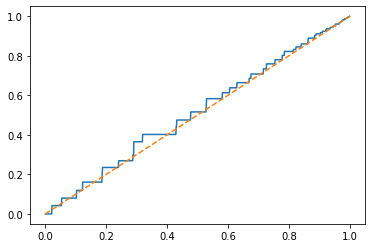

In [12]:
samples = torch.randn(1000)*0.1
plot_expected_coverage(samples, samples, 1000)